In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import Image

$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 1: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Object detection on TACO dataset

TACO is a growing image dataset of waste in the wild. It contains images of litter taken under diverse environments: woods, roads and beaches.

In [ ]:
Image('imgs/taco.png')

you can read more about the dataset here: https://github.com/pedropro/TACO

and can explore the data distribution and how to load it from here: https://github.com/pedropro/TACO/blob/master/demo.ipynb


The stable version of the dataset that contain 1500 images and 4787 annotations exist in `datasets/TACO-master`
You do not need to download the dataset.


### Project goals:

* You need to perform Object Detection task, over 7 of the dataset.
* The annotation for object detection can be downloaded from here: https://github.com/wimlds-trojmiasto/detect-waste/tree/main/annotations.
* The data and annotation format is like the COCOAPI: https://github.com/cocodataset/cocoapi (you can find a notebook of how to perform evalutation using it here: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb)
(you need to install it..)
* if you need a beginner guild for OD in COCOAPI, you can read and watch this link: https://www.neuralception.com/cocodatasetapi/ 

### What do i need to do?

* **Everything is in the game!** as long as your model does not require more then 8 GB of memory and you follow the Guidelines above.


### What does it mean?
* you can use data augmentation, rather take what's implemented in the directory or use external libraries such as https://albumentations.ai/ (notice that when you create your own augmentations you need to change the annotation as well)
* you can use more data if you find it useful (for examples, reviwew https://github.com/AgaMiko/waste-datasets-review)


### What model can i use?
* Whatever you want!
you can review good models for the coco-OD task as a referance:
SOTA: https://paperswithcode.com/sota/object-detection-on-coco
Real-Time: https://paperswithcode.com/sota/real-time-object-detection-on-coco
Or you can use older models like YOLO-V3 or Faster-RCNN
* As long as you have a reason (complexity, speed, preformence), you are golden.

### Tips for a good grade:
* start as simple as possible. dealing with APIs are not the easiest for the first time and i predict that this would be your main issue. only when you have a running model that learn, you can add learning tricks.
* use the visualization of a notebook, as we did over the course, check that your input actually fitting the model, the output is the desired size and so on.
* It is recommanded to change the images to a fixed size, like shown in here :https://github.com/pedropro/TACO/blob/master/detector/inspect_data.ipynb
* Please adress the architecture and your loss function/s in this notebook. if you decided to add some loss component like the Focal loss for instance, try to show the results before and after using it.
* Plot your losses in this notebook, any evaluation metric can be shown as a function of time and possibe to analize per class.

Good luck!

## Implementation

## Model Picking

As the task consists of object detection, and with inspiraton from part 6 of HW2's YOLOv3, we've choosed [YOLOv8](https://github.com/ultralytics/ultralytics) as a model, which is currently (unless YOLOv9 somehow shows up by the time this sentence would be read) the state of the art in terms of object detection. In addition for its SoT traits, its API is easy to use and the prediction results are neatly saved in a proper directory.

### Architecture

YOLOv8 consits of 24 convolutional layers (CNNs) followed by 2 fully connected layers (FCs).Of the 24 layers, 7 are regular CNN layers, and between each of them there's a C2F layer (8 in total) and lastly a single SPP layer is in the middle.

C2F(Coarse2Fine) layers addition are a new change from previous YOLO models. Each layer recieves the output of a CNN layer, whereas the output is devided to many different equal sized rectangles shaped mini images. Then, each image is converted to HSV histogram (AKA a historgram depicting the color distribution of the image). For each training class, a learnable query image is being fed to the C2F layer, which is also coverted to HSV histogram. Afterwards, each of the mini images is compared to the query image by cosine similarity, and the most similar mini-images to the query image would be picked, along their location in the bigger input image. This layer assists the model to concentrate on specific desired objects within the entire image, by querying the desired identification object and comparing it to the various image parts.

The middle SPP(Spatial Pyramid Pooling) layer exists since YOLOv3. By using spatial pyramid pooling net(SPP-net), rather than regular CNN layers requiring repeatedly computing of the convolutional features, this layer computes all feature maps from the entire map in one go and saving precious time. SPPF layer used in YOLOv8 is an enhanced version of SPP, using less FLOPs thus improving its efficiency.

### Loss & Metrics

YOLOv8 uses DFL(distributional focal loss) as its loss function. A focal loss function is a dynamically scale cross entropy loss which concentrates on difficult samples, and automatically down-weight the weight of easier examples for this task. When a sample metric is closer to the threshold it would have significantly higher effect than a sample which was far away from the threshold. By using the distributional aspect, the loss function can take into acount multiple samples at the same time, which is beneficial for object detecting whereas multiple objects can be presented at the same time in a single image.

YOLOv8, and all YOLO models in general, uses IoU (intersection over Union) metric to evaluate its performance and behave. As also explained in the tutorial for YOLO, IoU is calculated by dividing the AoO(Area of Overlap) by the AoU(Area of Union). As the images AoO increaces, hence the IoU value is increased as well. Due to it being divided by AoU, even if an annotation box completely surround the desired object, the IoU value would be less than 1, forcing the model to learn how to minimize the annotation box to raise the value of IoU and as result also make the annotation box accurately and tightly boxing the desired object.

YOLO8v and YOLO models in general main metrics are mAP50 and mAP50-95. mAP (Mean Average Precision), as explained in the YOLO tutorial, calculated as the area under the precision & recall curve of the model's predictions. In contrary to class prediction, the recall and precision are calculated by the value of IoU, whereas value above 0.5 would be positive and value under 0.5 would be considered negative.
However, this threshold of 0.5 is a bit constraining, and may introduce an undesireable bias towards mediocre results. Therefore, in addition to mAP50, we also observe the mAP50-95 metric, which checks the precision and recall values for various threshoulds between 0.5 to 0.95, and then returns the average of them all, giving a potentially better representation of the model robustness

## Pre-Processing


As YOLOv8 was already trained on object detection (and not the TACO dataset), we wanted to utillize that capability and create better results. The images' dimentions it got trained on were with 640x640 input, hence we wanted to alter the size of the images of the dataset accordignly. Furthermore, we stumbled upon a labeling problem whereas there are 60 labels in the data instead of the desired 7 labels. In Addition, some annotation's coordinates were inaccurate in terms they were bigger (or smaller) than the original possible coordinates of the image itself.

To tackle this problem we've used [RoboFlow](https://roboflow.com/), an online tool where images and relevant annotation files can be uploaded, altered by size, annotation labels and division for training, evaluation and test sub-datasets easily.

With this tool, we've done the following:
1. Altered Datasets images to be all 640x640 pixels.
2. Manualy stated to which of the 7 TACO-bboxes label the original 60 TACO labels should be changed.
3. Divided the dataset randomally to 70% training, 20% validaiton and 10% test.
4. By RoboFlow algorithm, fixed annotations of inaccurate coordinates (too big or too small than original image)
5. Created a yaml file which YOLOv8 can easily read to load the dataset for training, validating and predicting.

## Training

### Hyper Parameter Optimization


In order to get better results, we've decided to use the provided [YOLOv8n](https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt) model, with pretrained weights on object detection in general. 
We firstly trained the database for 100 epochs on default parameters as a base for improvement (Optimizer: SGD, Learning Rate: 0.1, Momentum:0.937).

Then, we decided to do a 3-dimension hyper-parameter grid-search, in order to find the optimal optimizer, learning rate and momentum hyper parameters.

We've chosen the optimizers SGD, Adam and AdamW, with the varying learning rates: 0.01, 0.005, 0.001, 0.0005, 0.0001 and momentums: 0.1, 0.5, 0.9, whereas in Adam and AdamW momentum stands for the beta1 hyper-parameter.

Each combination of optimizer, learning rate and momentun was run for 5 epochs, and both mAP50 and mAP50-95 metrics were picked for each run combination.

As we're still not 4th dimentional perception capable beings, we've separate the results to 2-d tables for easy analysis.

#### SGD

##### mAP50

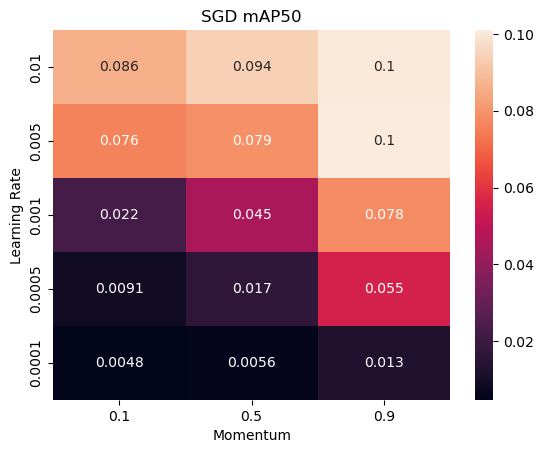

In [2]:
df = pd.read_csv('./project/SGD_50.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Momentum", ylabel="Learning Rate", title="SGD mAP50")

##### mAP50-95

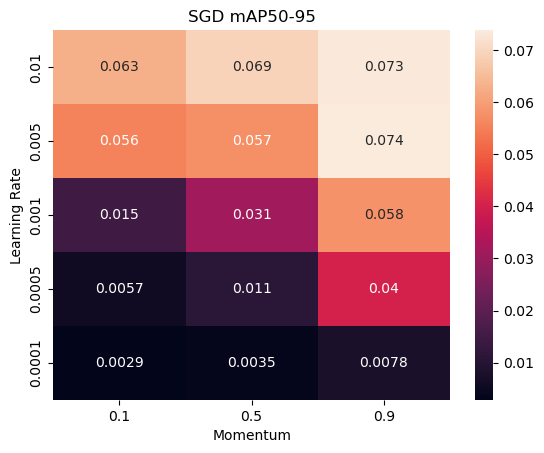

In [3]:
df = pd.read_csv('./project/SGD_50-95.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Momentum", ylabel="Learning Rate", title="SGD mAP50-95")

#### Adam

##### mAP50

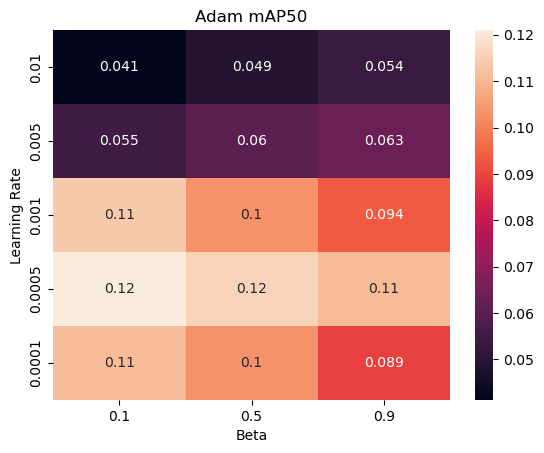

In [4]:
df = pd.read_csv('./project/ADAM_50.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Beta", ylabel="Learning Rate", title="Adam mAP50")

##### mAP50-95

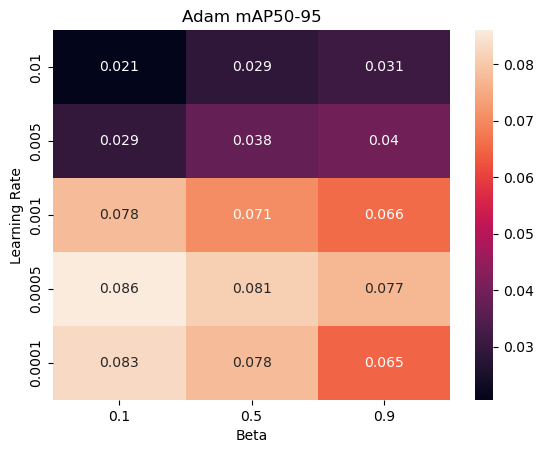

In [5]:
df = pd.read_csv('./project/ADAM_50-95.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Beta", ylabel="Learning Rate", title="Adam mAP50-95")

#### AdamW

##### mAP50

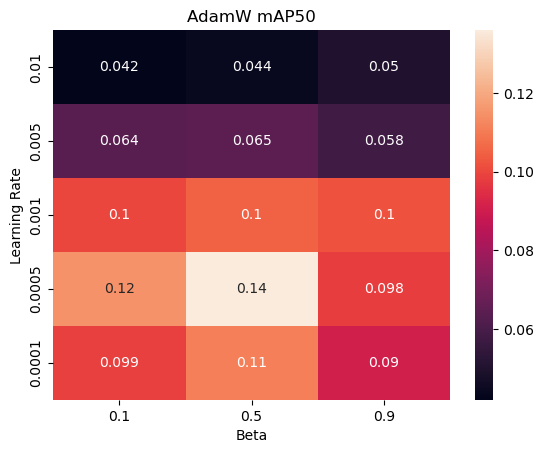

In [6]:
df = pd.read_csv('./project/ADAMW_50.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Beta", ylabel="Learning Rate", title="AdamW mAP50")

##### mAP50-95

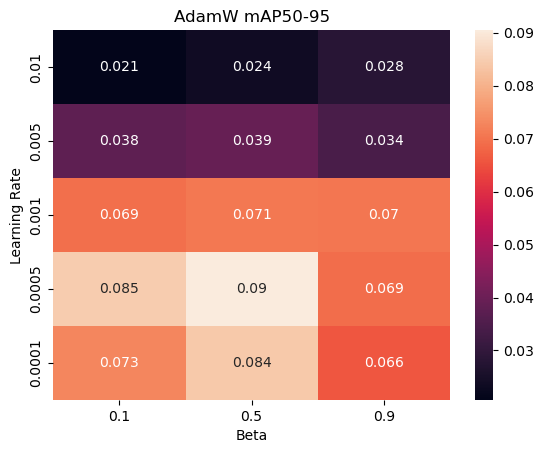

In [7]:
df = pd.read_csv('./project/ADAMW_50-95.csv', index_col=0)
ax = sns.heatmap(df, annot=True)
r = ax.set(xlabel="Beta", ylabel="Learning Rate", title="AdamW mAP50-95")

### Training with found HP

We've decided to pick the optimizer AdamW(lr = 0.005, beta=0.5) as its results was the highest among them all. We've run each for 100 epochs.

### Training Code

Below is the code used for training and for validating. After the training was done, the yaml file was edited so the test folder would be the validate folder, effectivily utilizing the "val" function to predict all test samples (the actual validation is being commenced straight  after the training automatically, hence this is the actual testing part). All result graphs are generated by YOLOv8.

## Results

### Training with no Optimization

As mentioned before, we first trained the model without any parameters alterations, rather than the pre-weights supplied with the provided model, as the base results for comparison purposes. We first observe the confusion matrix for the labels:

In [ ]:
Image('project/confusion_matrix_no_opt.png',width=1000, height=750)

We barley had any sample labeled 'bio' or 'other' in the dataset, hence it's no suprise the model couldn't learn these category at all. Not suprisingly, the most prominent label, 'metals_and_plastic', has also the best prediction accuracy of 0.47. It is also the prominent label that is given to an object, given it could be succesfully identified as not being background(AKA the model identified the existence of it as an object).

Image('project/confusion_matrix_no_opt.png',width=1000, height=750)

Similarly to the confusion matrix, a nice curve can be seen for 'metals_and_plastic' label, whereas for all the other labels, results are rather poor, due to their abudance in the dataset.

various losses and metric graphs:

In [ ]:
Image('project/results_no_opt.png',width=1000, height=500)

### Training with AdamW (with optimized parameters)

Image('project/confusion_matrix_AdamW.png',width=1000, height=750)

Although a slight decrease in accuracy (0.41 against 0.47) is presented for the label 'metal_and_plastic', other labels got significant improvent, for example, 'paper' (from 0.2 to 0.37) and 'non_recyclable' (from 0.06 to 0.16). We infer this behaviour is because given the better optimum reached with AdamW than the base model, with respect to the loss function of DFL, the model gave less significance to the 'metal_and_plastic' labeled samples which were easy to identify, and in return focused more on difficult ones like the label 'paper'. 

Image('project/confusion_matrix_AdamW.png',width=1000, height=750)

As expected (as we already observed this behaviour in the confusion matrix), the curve of 'metals_and_plastic' quality decreased over the base training. The curve of 'paper' was significantly improved, as seen at the 0.4-0.6 precision and recall area. Even 'glass' label is showing nice improvment to its curve.

various losses and metric graphs:

In [ ]:
Image('project/results_AdamW.png',width=1000, height=500)

As can be seen, in comparance to the base model, significant recall improvement, better dfl loss, and therefore also better box loss. All due to better mAP results.

### It's Test Time!

Image('project/results_compare.jpg')

As can be seen, due to the accuracy decrease of 'metal_and_plastic' label, sometimes objects in AdamW are wrongly classified whereas with no special optimization, with the higher accuracy for that label there are more correct classifications. However, for example, due to the increased mAP in AdamW, the drinking cup in the example above was succefully identified(and partially classified) by AdamW whereas the base training could not! This is seen again in the picture the the left of the drinking cup whereas AdamW manages to identify objects the base training couldn't (although adding some false positive, possibly imagianary object to the identifiction). This can be seen yet again in the sand image at the bottom.